In [17]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import glob, os
from glob import glob
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [18]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [19]:
data_dir = ''

In [20]:
# Verification of the number of Images 

# load filenames for human and dog images
size = 0
size = np.array(glob(data_dir+"images/*"))

# Check one image
#Image.open(open("/kaggle/input/plant-pathology-2020-fgvc7/images/Train_3.jpg", 'rb'))

# print number of images in each dataset
print('There are %d total images.' % len(size))

sample_csv = pd.read_csv(data_dir + 'sample_submission.csv')
test_csv = pd.read_csv(data_dir + 'test.csv')
train_csv = pd.read_csv(data_dir + 'train.csv')

train_csv

There are 3642 total images.


,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [61]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, id_col, target_col, root_dir, sufix=None, transform=None):
        """
        Args:
            csv_file   (string):             Path to the csv file with annotations.
            root_dir   (string):             Directory with all the images.
            id_col     (string):             csv id column name.
            target_col (string):             csv target column name.
            sufix      (string, optional):   Optional sufix for samples.
            transform  (callable, optional): Optional transform to be applied on a sample.
        """
        self.data      = pd.read_csv(csv_file)
        self.id        = id_col
        self.target    = target_col
        self.root      = root_dir
        self.sufix     = sufix
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get the image name at the different idx
        img_name = self.data.loc[idx, self.id]
        
        # if there is not sufic, nothing happened. in this case sufix is '.jpg'
        if self.sufix is not None:
            img_name = img_name + self.sufix
        
        # it opens the image of the img_name at the specific idx
        image = Image.open(os.path.join(self.root, img_name))
        
        # if there is not transform nothing happens, here we defined below two transforms for train and for test
        if self.transform is not None:
            image = self.transform(image)
        
        # define the label based on the idx
        label = self.data.iloc[idx, 1:5].values.astype('int64')
        label = np.argwhere(label ==1)
        label = label.item(0)
        label = torch.tensor(label)
        
        return image, label
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

params = {
    'id_col':     'image_id',  
    'target_col': ['healthy', 'multiple_diseases', 'rust', 'scab'],
    'sufix':      '.jpg',
    'transform':  data_transforms['train']
}

train_dataset = CustomDataset(csv_file=data_dir+'train.csv', root_dir=data_dir+'images', **params)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [62]:


print('TRAINING')
img, lab = train_dataset.__getitem__(0)

print('DATASET')
print('image at the first row: ', img.shape)
print('image size at the first row: {}'.format(img.size()))
print('Lab at the first row: ', lab)
print('lab format at the first row: {}'.format(lab))
print('lab format at the first row: {}'.format(lab.shape))


print()
print('Train Loader type')
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()
print()
print('DATALOADER')
print('images type on batch size = {}'.format(type(images)))
print('images shape on batch size = ', images.shape)
print('labels type on batch size = {}'.format(type(labels)))
print('labels shape on batch size = ', labels.shape)



TRAINING
DATASET
image at the first row:  torch.Size([3, 224, 224])
image size at the first row: torch.Size([3, 224, 224])
Lab at the first row:  tensor(3)
lab format at the first row: 3
lab format at the first row: torch.Size([])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER
images type on batch size = <class 'torch.Tensor'>
images shape on batch size =  torch.Size([4, 3, 224, 224])
labels type on batch size = <class 'torch.Tensor'>
labels shape on batch size =  torch.Size([4])


In [28]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # CL sees 224 x 224 x 3 image tensor
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv11= nn.Conv2d(16, 16, 2, padding=0)
        self.conv1_1 = nn.Conv2d(16, 32, 3, padding=1)
        
        # CL sees 112 x 112 x 16
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv22 = nn.Conv2d(64, 64, 2, padding=0)
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        
        
        # CL sees 56 x 56 x 32
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv33 = nn.Conv2d(256, 256, 2, padding=0)
        self.conv3_1 = nn.Conv2d(256, 512, 3, padding=1)
        
        
        # CL sees 56 x 56 x 32
        #self.conv4 = nn.Conv2d(256, 512, 2, padding=0)
        #self.conv4_1 = nn.Conv2d(512, 512, 3, padding=1)
        #self.batchnorm512 = nn.BatchNorm2d(512)
        
        #batchNorm
        self.batchnorm16 = nn.BatchNorm2d(16)
        self.batchnorm32 = nn.BatchNorm2d(32)
        self.batchnorm64 = nn.BatchNorm2d(64)
        self.batchnorm128 = nn.BatchNorm2d(128)
        self.batchnorm256 = nn.BatchNorm2d(256)
        self.batchnorm512 = nn.BatchNorm2d(512)
        self.batchnorm1024 = nn.BatchNorm2d(1024)
        self.batchnorm2048 = nn.BatchNorm2d(2048)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(3, 3)
        self.AVGpool = nn.AvgPool2d(3, 3)
        
        # linear layer (64 * 28 * 28 -> 500)
        self.fc1 = nn.Linear(512 * 7 * 7, 500)
        
        # linear layer (500 -> 250)
        self.fc2 = nn.Linear(500, 250)
        
        # linear layer 
        #self.fc3 = nn.Linear(500, 250)
        
        # linear layer (250 -> 4)
        self.fc4 = nn.Linear(250, 4)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout2d(0.2)
        
        # LogSoftmax
        self.LogSM = nn.LogSoftmax()
    
    def forward(self, x):
        ## Define forward behavior
        # 1st CNN
        # 3 => 16
        x = self.conv1(x)
        x = F.relu6(x)
        x = self.conv11(x)
        x = F.relu6(x)
        x = self.batchnorm16(x)
        
        # 16 => 32
        x = self.conv1_1(x)
        x = F.relu6(x)
        x = self.batchnorm32(x)
        
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        # 2nd CNN
        # 32 => 64
        x = self.conv2(x)
        x = F.relu6(x)
        x = self.conv22(x)
        x = F.relu6(x)
        x = self.batchnorm64(x)
        
        # 64 => 128
        x = self.conv2_1(x)
        x = F.relu6(x)
        x = self.batchnorm128(x)
        
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        # 3rd CNN
        # 128 => 256
        x = self.conv3(x)
        x = F.relu6(x)
        x = self.conv33(x)
        x = F.relu6(x)
        x = self.batchnorm256(x)

        # 256 => 512
        x = self.conv3_1(x)
        x = F.relu6(x)
        x = self.batchnorm512(x)
        
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        
        #print(x.shape)
        # flatten image input
        #print(x.shape)
        x = x.view(-1, 512 * 7 * 7)
        #x = self.dropout(x)
        
        # add 1st hidden layer, with relu activation function
        x = self.fc1(x)
        x = F.relu6(x)
        x = self.dropout(x)
        
        #h2
        x = self.fc2(x)
        x = F.relu6(x)
        x = self.dropout(x)
        
        #h3
        #x = self.fc3(x)
        #x = F.relu(x)
        #x = self.dropout(x)
        x = self.LogSM(self.fc4(x))

        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_patho = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

    
model_patho = Net()


In [29]:
### TODO: select loss function
criterion = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer = optim.SGD(model_patho.parameters(), lr=0.001)

In [33]:
def train(n_epochs, loaders, model, optimizer, criterion):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for idx, (data, target) in enumerate(loaders):

            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            #update training loss
            train_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders.sampler)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            torch.save(model.state_dict(), 'model_patho_32.pt')
            ))
            
    # return trained model
    return model

In [34]:
model_res = train(20, train_loader, model_patho, optimizer, criterion)



C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:132: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 1.004141
Epoch: 2 	Training Loss: 0.960683
Epoch: 3 	Training Loss: 0.938496
Epoch: 4 	Training Loss: 0.916939
Epoch: 5 	Training Loss: 0.895067
Epoch: 6 	Training Loss: 0.864333
Epoch: 7 	Training Loss: 0.851494
Epoch: 8 	Training Loss: 0.829878
Epoch: 9 	Training Loss: 0.820450
Epoch: 10 	Training Loss: 0.794355
Epoch: 11 	Training Loss: 0.771522
Epoch: 12 	Training Loss: 0.762736
Epoch: 13 	Training Loss: 0.746701
Epoch: 14 	Training Loss: 0.733960
Epoch: 15 	Training Loss: 0.707590
Epoch: 16 	Training Loss: 0.693949
Epoch: 17 	Training Loss: 0.685360
Epoch: 18 	Training Loss: 0.700350
Epoch: 19 	Training Loss: 0.678340
Epoch: 20 	Training Loss: 0.661870


In [35]:
# load the model that got the best validation accuracy
model_res.load_state_dict(torch.load('model_patho_32.pt'))

<All keys matched successfully>

# TEST

In [258]:
class CustomDataset_test(Dataset):
    def __init__(self, csv_file, id_col, target_col, root_dir, sufix=None, transform=None):
        """
        Args:
            csv_file   (string):             Path to the csv file with annotations.
            root_dir   (string):             Directory with all the images.
            id_col     (string):             csv id column name.
            target_col (string):             csv target column name.
            sufix      (string, optional):   Optional sufix for samples.
            transform  (callable, optional): Optional transform to be applied on a sample.
        """
        self.data      = pd.read_csv(csv_file)
        self.id        = id_col
        self.target    = target_col
        self.root      = root_dir
        self.sufix     = sufix
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get the image name at the different idx
        img_name = self.data.loc[idx, self.id]
        
        # if there is not sufic, nothing happened. in this case sufix is '.jpg'
        if self.sufix is not None:
            img_name = img_name + self.sufix
        
        # it opens the image of the img_name at the specific idx
        image = Image.open(os.path.join(self.root, img_name))
        
        # if there is not transform nothing happens, here we defined below two transforms for train and for test
        if self.transform is not None:
            image = self.transform(image)
        
        label = self.data.loc[idx, self.id]
        label = int(label[5:])
        label = torch.tensor(label)
        
        return image, label

data_transforms_test = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

params = {
    'id_col':     'image_id',  
    'target_col': ['healthy', 'multiple_diseases', 'rust', 'scab'],
    'sufix':      '.jpg',
    'transform':  data_transforms['test']
}

test_dataset = CustomDataset_test(csv_file=data_dir+'test.csv', root_dir=data_dir+'images', **params)
test_loader = DataLoader(test_dataset, batch_size = 4, shuffle=True)




In [261]:
print('TRAINING')
img_test, lab_test = test_dataset.__getitem__(0)

print('DATASET TEST')
print('image at the first row: {}', img_test.shape)
print('image size at the first row: {}'.format(img_test.size()))
print('Lab at the first row: ', lab_test)
print('lab format at the first row: {}'.format(lab_test))
print('lab format at the first row: {}'.format(lab_test.shape))

print()
print('Train Loader type')
test_iter = iter(test_loader)
print(type(test_iter))


images_test, labels_test = train_iter.next()
print()
print('DATALOADER TEST')
print('images test',images_test[0][0][0][0])
print('images type on batch size = {}'.format(type(images_test)))
print('images shape on batch size = {}', images_test.shape)
print('labels type on batch size = {}'.format(type(labels_test)))
print('labels shape on batch size = {}', labels_test)

TRAINING
DATASET TEST
image at the first row: {} torch.Size([3, 224, 224])
image size at the first row: torch.Size([3, 224, 224])
Lab at the first row:  tensor(0)
lab format at the first row: 0
lab format at the first row: torch.Size([])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER TEST
images test tensor(0.5922)
images type on batch size = <class 'torch.Tensor'>
images shape on batch size = {} torch.Size([4, 3, 224, 224])
labels type on batch size = <class 'torch.Tensor'>
labels shape on batch size = {} tensor([3, 2, 0, 0])


data_iter
image test data tensor([[[[0.2431, 0.2431, 0.2431,  ..., 0.3137, 0.3059, 0.3020],
          [0.2471, 0.2471, 0.2471,  ..., 0.3098, 0.3098, 0.3059],
          [0.2510, 0.2510, 0.2510,  ..., 0.3020, 0.3059, 0.3059],
          ...,
          [0.2196, 0.2157, 0.2157,  ..., 0.0902, 0.0980, 0.1059],
          [0.2314, 0.2235, 0.2235,  ..., 0.0902, 0.0941, 0.0941],
          [0.2471, 0.2392, 0.2353,  ..., 0.0863, 0.0902, 0.0902]],

         [[0.3961, 0.3961, 0.4000,  ..., 0.4039, 0.3922, 0.3804],
          [0.4000, 0.4000, 0.4039,  ..., 0.4078, 0.4078, 0.3961],
          [0.4039, 0.4039, 0.4039,  ..., 0.4039, 0.4039, 0.4000],
          ...,
          [0.2471, 0.2392, 0.2392,  ..., 0.1804, 0.1882, 0.2118],
          [0.2706, 0.2588, 0.2588,  ..., 0.1804, 0.1882, 0.2000],
          [0.2941, 0.2863, 0.2863,  ..., 0.1765, 0.1843, 0.1961]],

         [[0.2275, 0.2157, 0.2039,  ..., 0.2941, 0.2863, 0.2824],
          [0.2275, 0.2196, 0.2078,  ..., 0.2941, 0.2941, 0.2863],
          [0.231

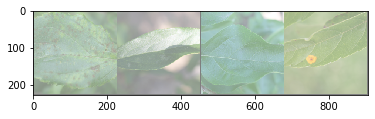

In [263]:
classes = ('healthy', 'multiple_diseases', 'rust', 'scab')

dataiter_test = iter(test_loader)
print('data_iter\n',dataiter_test)
images_test = dataiter_test.next()
images_test_data = images_test[0]
print('image test data',images_test_data)
images_test_label = images_test[1]
print(images_test_label)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print images
imshow(torchvision.utils.make_grid(images_test_data))
#print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [234]:
model_test = Net()
model_test.load_state_dict(torch.load('model_patho_32.pt'))
model_test = model_test.eval()

outputs_test = model_test(images_test_data)



C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:132: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [235]:
out_fwd = model_test.forward(images_test_data)
print('Result preditcion model on dataset:\n {}\n'.format(out_fwd))
probs = torch.exp(out_fwd)
print('probs\n', probs)
top_probs, top_labs = probs.topk(4)
print('top_probs:\n {} \n top_labs:\n {}'.format(top_probs, top_labs))
print(classes[top_labs[0][0].detach().numpy()])
print(classes[top_labs[1][0].detach().numpy()])
print(classes[top_labs[2][0].detach().numpy()])
print(classes[top_labs[3][0].detach().numpy()])

Result preditcion model on dataset:
 tensor([[-4.2184, -5.0450, -0.0236, -6.1576],
        [-1.7251, -1.9658, -0.5481, -2.2656],
        [-0.7671, -4.0282, -3.2027, -0.7399],
        [-1.6893, -1.8021, -0.7801, -1.6501]], grad_fn=<LogSoftmaxBackward>)

probs
 tensor([[0.0147, 0.0064, 0.9767, 0.0021],
        [0.1782, 0.1400, 0.5780, 0.1038],
        [0.4644, 0.0178, 0.0407, 0.4772],
        [0.1847, 0.1649, 0.4584, 0.1920]], grad_fn=<ExpBackward>)
top_probs:
 tensor([[0.9767, 0.0147, 0.0064, 0.0021],
        [0.5780, 0.1782, 0.1400, 0.1038],
        [0.4772, 0.4644, 0.0407, 0.0178],
        [0.4584, 0.1920, 0.1847, 0.1649]], grad_fn=<TopkBackward>) 
 top_labs:
 tensor([[2, 0, 1, 3],
        [2, 0, 1, 3],
        [3, 0, 2, 1],
        [2, 3, 0, 1]])
rust
rust
scab
rust


C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:132: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [219]:
plok, predicted = torch.max(outputs_test, 1)

print(plok)
print(predicted)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

tensor([-0.1267, -0.4606, -0.9570, -0.9749], grad_fn=<MaxBackward0>)
tensor([2, 3, 3, 0])
Predicted:   rust  scab  scab healthy


In [ ]:
res_add = ['Test_'+str(idx), 0.9767, 0.0147, 0.0064, 0.0021]
print(list_topp)

submission_df_test.loc[idx] = list_topp
print(submission_df_test)


print(type(list))

# Submission

In [146]:
submission_df = pd.read_csv(data_dir + 'sample_submission.csv')

submission_df.iloc[:, 1:] = 0

submission_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0,0,0,0
1,Test_1,0,0,0,0
2,Test_2,0,0,0,0
3,Test_3,0,0,0,0
4,Test_4,0,0,0,0


In [ ]:
submission_df_test = pd.read_csv(data_dir + 'sample_submission.csv')

model_test = Net()
model_test.load_state_dict(torch.load('model_patho_32.pt'))
model_test = model_test.eval()

batch_size = 4

for data in enumerate(test_loader):
    images_data = data[1][0]
    #print(images_data)
    label_data = data[1][1]
    #print(label_data)   
    probs = torch.exp(model_test(images_data))
    #print(probs)
    label_data = label_data.numpy()
    #print(label_data)
    probs = probs.detach().numpy()
    #print(probs)
    for i in range(len(label_data)):
        #print(i)
        ind = label_data[i]
        #print(ind)
        res_probs = probs[i]
        #print(res_probs)
        res_add = ['Test_'+str(ind), res_probs[0], res_probs[1],res_probs[2],res_probs[3]]
        submission_df_test.loc[ind] = res_add         
        
pd.set_option("display.max_rows", 10, "display.max_columns", None)
print(submission_df_test)
submission_df_test.to_csv(path_or_buf='sample_submission_2.csv', index=False)
